In [26]:
from mit_semseg.utils import colorEncode
from sky_segmentation.modules.models import (
    PretrainedSegmentationModule, 
    SkyPretrainedSegmentationModule, 
    get_inference_transform
)
import torch
import PIL
import numpy as np
import csv 
import scipy.io
import PIL.Image

## Helpers Functions

In [27]:
colors = scipy.io.loadmat('../artifacts/data/metadata/color150.mat')['colors']
names = {}
with open('../artifacts/data/metadata/object150_info.csv') as f:
    reader = csv.reader(f)
    next(reader)
    for row in reader:
        names[int(row[0])] = row[5].split(";")[0]

def visualize_result(img, pred, index=None):
    # filter prediction class if requested
    if index is not None:
        pred = pred.copy()
        pred[pred != index] = -1
        print(f'{names[index+1]}:')
        
    # colorize prediction
    pred_color = colorEncode(pred, colors).astype(np.uint8)

    # aggregate images and save
    im_vis = np.concatenate((img, pred_color), axis=1)
    display(PIL.Image.fromarray(im_vis))

# load transforms
transforms = get_inference_transform()

## Sky Index

In [28]:
mat_filename = "../artifacts/data/metadata/objectName150.mat"
mat = scipy.io.loadmat(mat_filename, simplify_cells=True)
list_of_object = mat["objectNames"].tolist()
id2label = {i: label for i, label in enumerate(list_of_object)}
label2id = {label: i for i, label in enumerate(list_of_object)}
num_labels = len(id2label)

print(f"Number of labels: {num_labels}")
print("Sky index:", label2id["sky"])

Number of labels: 150
Sky index: 2


## Load & Preprocess Image

In [29]:
path = "../artifacts/data/ADEChallengeData2016/images/training/ADE_train_00000983.jpg"
segmentation_path = "../artifacts/data/ADEChallengeData2016/annotations/training/ADE_train_00000983.png"
segmentation_mask = PIL.Image.open(segmentation_path)

pil_image = PIL.Image.open(path).convert('RGB')
img_original = np.array(pil_image)
img_data = transforms(pil_image)
singleton_batch = {'img_data': img_data[None]}
output_size = img_data.shape[1:]

In [30]:
pil_image.size

(450, 338)

## Load Pretrained Segmentation Model

In [31]:
encoder_weights_path = '../artifacts/models/ckpt/ade20k-resnet50dilated-ppm_deepsup/encoder_epoch_20.pth'
decoder_weights_path = '../artifacts/models/ckpt/ade20k-resnet50dilated-ppm_deepsup/decoder_epoch_20.pth'

# load the pretrained segmentation module
segmentation_module = PretrainedSegmentationModule(encoder_weights_path, decoder_weights_path)

Loading weights for net_encoder
Loading weights for net_decoder


## Run Inference

In [32]:
# Run the segmentation at the highest resolution.
with torch.no_grad():
    pred = segmentation_module(singleton_batch, output_size=output_size)

pred = pred.cpu()[0].numpy()

## Visualise Results

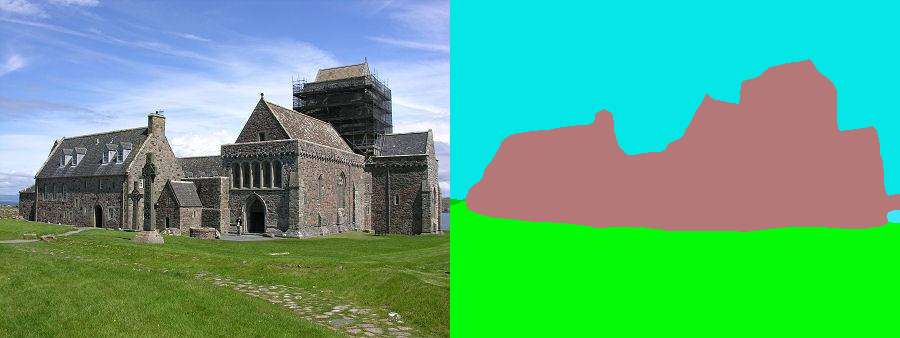

In [33]:
visualize_result(img_original, pred)

## Load Sky Segmentation Model

In [34]:
# load the pretrained sky segmentation module
sky_segmentation_module = SkyPretrainedSegmentationModule(encoder_weights_path, decoder_weights_path)

Loading weights for net_encoder
Loading weights for net_decoder


## Run Inference

In [35]:
# Run the segmentation at the highest resolution.
with torch.no_grad():
    pred = sky_segmentation_module(singleton_batch, image_size=output_size)
pred = pred.cpu().numpy().squeeze()

In [36]:
# convert 1 mask to 2 
pred = np.where(pred == 1, 2, pred)
# convert 0 mask to -1
pred = np.where(pred == 0, -1, pred)

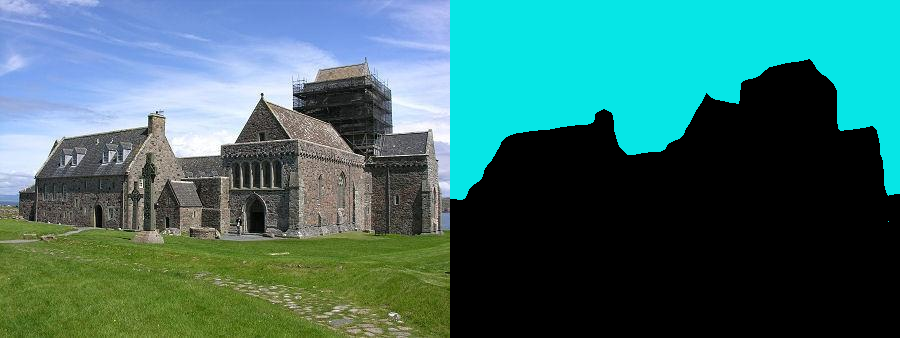

In [37]:
visualize_result(img_original, pred)